# Theoretical setup

# PAGE
Our goal is to minimize function $f(x)$ that could be presented as finite-sum of terms:
$$f(x) = \sum_{i = 1}^{N} f_{i}(x)$$
There are a lot intesive research about a gradient methods for solving this task. The main drivers in this area are Gradient descent Stochastic Gradient Descent (SGD).\
Gradient Descent suppose that we can computing of gradient w.r.t to weights for all dataset is reachable and quite cheap. It is not true in case of high dimensional data, so we need to use the Stochastic Gradient Descent. This method aim to combat problem of high dimensionality. The main idea is to sample data points somehow randomly in a suitable amount. Common scheme of "Your hero" Gradient descent is the following:
$$x_{t + 1} = x_{t} - \eta * \nabla f_{i}(x_t)$$
There a lot of research that directed to prove the convergnce of such schemes under some assumptions w.r.t to function properties such as convexity, Lipschitz-gradient, smoothness and another.\
Nowadays, the main questions about these methods are what is the gradient complexity of this methods and how many steps we need to make until converge. For the mentioned methods it is widely known. 
$$\#grad(GD) = O(\frac{n}{\epsilon^2}), \;\;\;\; \#grad(SGD) = O(\frac{1}{\epsilon^4})$$
And the another field of research is variance reduction methods.
 
The PAGE is a loopless method. PAGE slightly modified SGD and shows superior quality for nonconvex tasks. \
In particular, for non-convex finite-sum with L Lipschitz-gradient it shows gradient complexity $O(n + \frac{\sqrt{n}}{\epsilon^2})$.

Let's consider the algorithm and discuss its proterties closer:

--------

# Algorithm 1 ProbAbilistic Gradient Estimator (PAGE)

**Input:** initial point $x^0$, stepsize $\eta$, minibatch size $b, b' < b$, probability $\{p_t\} \in (0, 1]$

1: $g^0 = \frac{1}{b} \sum_{i \in I} \nabla f_i(x^0)$ &emsp;&emsp;// $I$ denotes random minibatch samples with $|I| = b$ \
2: **for** $t = 0, 1, 2, \ldots$ **do** \
3: &emsp;$x^{t+1} = x^t - \eta g^t$ \
4: &emsp;$g^{t+1} = 
\begin{cases} 
\frac{1}{b} \sum_{i \in I} \nabla f_i(x^{t+1}) & \text{with probability } p_t \\
g^t + \frac{1}{b'} \sum_{i \in I'} (\nabla f_i(x^{t+1}) - \nabla f_i(x^t)) & \text{with probability } 1 - p_t
\end{cases}$ \
5: **end for**

**Output:** $\hat{x}_T$ chosen uniformly from $\{x^t\}_{t \in [T]}$

-----

The main points of the authors:
* Low complexity of the second case if $b' << b$.
* Converges faster than usual SGD
* Easy to implement deriving from basic SGD
* Some kind of optimality of PAGE in case of nonconvex regime
* Switching to linear comlexity under the PL assumpltion (restriction on the gradient norm)

-----

**Special moments:**
1. If $p_t = 1 \Rightarrow$ PAGE transforms to  SGD. Moreover, if $b = n$  then PAGE transforms to GD.
2. Given $\eta \leq \frac{1}{L * (1 + \sqrt(\frac{1 - p_t}{p_tb}))}$ (theory says) we get optimal convergence speed .
3. We have less hyperparameters. We have no loop over number of epochs.

----

**Convergence understanding**

In fact, this method is just SGD with less amount of large batches. What is the second case in $g_t$ update? It is unbiased estimation of gradient. In the same it is some kind of an adjustment. This adjustment could be considered as a hessian approximation. So after a lot iteration in the gradient direction we finish with help of the 'second-order' oracle. Also we know that to converge we don't always need all data volume (SGD). So after compute-consuming part (step over $b$ examples) we have a lot of cheap but meaningful iterations and use some kind of 'inertia' after the first stage. It could be imagine like one step in the 'good' direction and many fine-grained steps to improve slightly.

----
**Experiments**

We provide a number of experiments to compare original SGD and PAGE approach:
* Datasets: mushrooms, MNIST
* Models: convnet, ResNet18, LeNet, linear model
* Metrics: loss, accuracy
* LR for linear model is from paper $\eta = \frac{1}{L(1 + \sqrt(\frac{1 - p_t}{p_tb}))}$, for NN's we found the best over logarithmic grid from 1e-5 to 1e-1.
* $b' = \sqrt(b)$ - from the paper
------
**Implementation details**

To implement PAGE we've created custom torch optimizer and redifine its basic function for our goals. Choosing of $g_t$ update case were relied on sampling r.v. from $U(0, 1)$

# Code and Experiments

## Imports

In [ ]:
#@title Insatlling Pyorch

!pip install torch
!pip install torchvision

In [1]:
#@title Import Dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import torchvision
from torch.autograd import Variable

## Basic definitions

In [2]:
#@title Define Hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = 500 # number of nodes at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 20 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [3]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel images
    transforms.Resize((224, 224)),  # Resize to 224x224 if using standard ResNet
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean and std
])

train_data_3d = dsets.MNIST(root = './data', train = True,
                        transform = transform, download = True)

test_data_3d = dsets.MNIST(root = './data', train = False,
                       transform = transform)

In [4]:
#@title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

train_gen_3d = torch.utils.data.DataLoader(dataset = train_data_3d,
                                             batch_size = batch_size,
                                             shuffle = True)

test_gen_3d = torch.utils.data.DataLoader(dataset = test_data_3d,
                                      batch_size = batch_size,
                                      shuffle = False)

In [5]:
dataset = "mushrooms.txt"
from sklearn.datasets import load_svmlight_file
import numpy as np


data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Custom classes implementations

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader

class MushroomsDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.tensor(data).float()
        self.targets = torch.tensor(targets).float()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        target = self.targets[index]

        return sample, target


In [8]:
mushrooms_dataset_train = MushroomsDataset(X_train, y_train)
mushrooms_dataset_valid = MushroomsDataset(X_test, y_test)

mushrooms_loader_train = DataLoader(mushrooms_dataset_train, batch_size=32, shuffle=True, pin_memory=True)
mushrooms_loader_valid = DataLoader(mushrooms_dataset_valid, batch_size=256, shuffle=True, pin_memory=True)

In [23]:
#@title Define model class

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Net,self).__init__()
        self.num_classes = num_classes
        # self.fc1 = nn.Linear(input_size, hidden_size)
        # self.relu = nn.ReLU()
        self.fc2 = nn.Linear(input_size, num_classes)

    def forward(self,x):
        # out = self.fc1(x)
        # out = self.relu(out)
        out = self.fc2(x)
        if self.num_classes == 1:
            return out.view(-1)
        return out


class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes

        self.features = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(6, 16, kernel_size = 5),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size = 2)
        )

        with torch.no_grad():
            input_linear_size = torch.flatten(self.features(torch.zeros((2, 1, 28, 28))), 1).shape[1]

        self.classifier = nn.Sequential(
            nn.Linear(input_linear_size, 120),
            nn.Tanh(),
            nn.Linear(120, 84),
            nn.Tanh(),
            nn.Linear(84, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        logit = self.classifier(x)
        return logit
    
mnist_model = lambda x: nn.Sequential(
                    nn.Conv2d(1, 16, 3),
                    nn.BatchNorm2d(16),
                    nn.ReLU(),
                    nn.Conv2d(16, 32, 3),
                    nn.BatchNorm2d(32),
                    nn.ReLU(),
                    nn.Conv2d(32, 64, 3),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                    nn.Conv2d(64, 128, 3),
                    nn.BatchNorm2d(128),
                    nn.ReLU(),

                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten(),

                    nn.Linear(128, 64),
                    nn.ReLU(),
                    nn.Linear(64, 10)
                )

In [10]:
import torch
import torch.nn as nn

class PAGE(torch.optim.Optimizer):

    # Init Method:
    def __init__(self, params, lr=1e-3):
        super(PAGE, self).__init__(params, defaults={'lr': lr})
        self.state = dict()
        for group in self.param_groups:
            for p in group['params']:
                self.state[p] = dict(g=torch.zeros_like(p.data), prev_grad=torch.zeros_like(p.data))

    # Step Method
    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                a = p.data.clone()
                p.data = p.data - group['lr'] * self.state[p]['g']
    
    @torch.no_grad()
    def save_grads(self):
        for group in self.param_groups:
            for p in group['params']:
                self.state[p]['prev_grad'] = p.grad.data
    
    @torch.no_grad()
    def update_g(self, short: bool=1):
        for group in self.param_groups:
            for p in group['params']:
                if short:
                    self.state[p]['g'] = p.grad.data
                else:
                    self.state[p]['g'] = self.state[p]['g'] + (p.grad.data - self.state[p]['prev_grad'])

    def check_grad_none_(self):
        for group in self.param_groups:
            for p in group['params']:
                if not p.grad is None:
                    return False
        return True
    
    def check_grad_zero_(self):
        for group in self.param_groups:
            for p in group['params']:
                if not torch.allclose(p.grad, 0):
                    return False
        return True


In [11]:
def loss_mushrooms(y_pred, y, reduction='none'):
    assert len(y_pred.shape) == len(y.shape) == 1
    if reduction == 'none':
        return torch.log(1 + torch.exp(-y * y_pred))
    else:
        return np.mean(torch.log(1 + torch.exp(-y * y_pred)))

## Start of experiments

### Utils

In [12]:
#@title Build the model

net = Net(input_size, hidden_size, num_classes)
resnet = torchvision.models.resnet18(num_classes=num_classes, pretrained=False)
lenet = LeNet5(num_classes)
if torch.cuda.is_available():
    net.cuda()

/home/sasha/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sasha/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [13]:
#@title Define loss-function & optimizer

loss_function = nn.CrossEntropyLoss(reduction='none')
loss_binary = loss_mushrooms


In [14]:
def get_idx(batch_size: int, batch_size_: int):
    if batch_size <= batch_size_:
        return torch.arange(batch_size)
    unif = torch.ones(batch_size)
    idx = unif.multinomial(batch_size_, replacement=False)
    return idx

In [15]:
def accuracy(label, preds):
    if preds.shape[-1] == 10:
        predict = torch.argmax(preds, axis=1)
        res = (label == predict).float().mean()
        return res
    else:
        predict =  2 * (preds > 0.).int() - 1
        res = (label == predict).float().mean()
        return res

In [16]:
def get_new_items(loader, generator):
    try:
        X, labels = next(loader)
    except StopIteration:
        loader = iter(generator)
        X, labels = next(loader)
    return X, labels, loader

In [17]:
logger = {}

In [24]:
import torch
import numpy as np

def train_model(train_gen, valid_gen, net, optimizer, loss_function, batch_size, prob_t, num_epochs, num_valids, linearize=False):
    net.train()
    k = 0

    # Batch size definition
    sampler = torch.distributions.uniform.Uniform(0, 1)
    batch_size_ = int(batch_size ** 0.5)
    
    # Metrics staff
    train_loss = []
    test_acc = []
    num_grad_steps = 0
    
    # Definition number of steps
    num_iter = len(train_gen) * num_epochs
    num_valids = len(train_gen) // num_valids
    
    # Warm up step
    loader = iter(train_gen)
    X, labels = next(loader)
    if len(X.shape) > 2 and linearize:
        X = X.view(-1, 28 * 28)
    X = X.cuda()
    labels = labels.cuda()

    optimizer.zero_grad()
    outputs = net(X)
    loss = loss_function(outputs, labels)
    loss.mean().backward(retain_graph=True)
    optimizer.update_g(short=True)
    
    while k < num_iter:        
        a = sampler.rsample()

        if a > prob_t:
            idxs = get_idx(len(loss), batch_size_)
            optimizer.zero_grad(set_to_none=False)
            loss[idxs].mean().backward()
            optimizer.save_grads()

        optimizer.step()

        # Update g
        if a < prob_t:
            X, labels, loader = get_new_items(loader, train_gen)
            if len(X.shape) > 2 and linearize:
                X = X.view(-1, 28 * 28)
            X = X.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outputs = net(X)
        loss = loss_function(outputs, labels)

        if a < prob_t:
            loss.mean().backward(retain_graph=True)
            optimizer.update_g(short=True)
            num_grad_steps += batch_size
        else:
            loss[idxs].mean().backward(retain_graph=True)
            optimizer.update_g(short=False)
            num_grad_steps += batch_size_
            
        train_loss += [(loss.detach().mean().cpu().item(), num_grad_steps)]
        k += 1

        if (k + 1) % num_valids == 0:
            net.eval()
            metrics = []
            with torch.no_grad():
                for X_test, labels_test in valid_gen:
                    if len(X.shape) > 2 and linearize:
                        X_test = X_test.view(-1, 28 * 28)
                    X_test = X_test.cuda()
                    labels_test = labels_test.cuda()

                    outputs = net(X_test)
                    metrics += [accuracy(labels_test.cpu(), outputs.detach().cpu()).item()]
            test_acc += [(np.mean(metrics), num_grad_steps)]

            net.train()

        if (k + 1) % 100 == 0:
            print('Step [%d/%d], Loss: %.4f' %(k+1, num_iter, train_loss[-1][0]))

    return train_loss, test_acc


### MNIST

#### Lenet PAGE

In [101]:
#@title Build the model

for lr in [1e-2]:
    for batch_size in [64, 256]:
        train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

        test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                             batch_size = batch_size,
                                             shuffle = False)
        net = LeNet5(10).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)
        batch_size_ = np.sqrt(batch_size)
        prob_t = batch_size_ / (batch_size + batch_size_)
        res = train_model(
            train_gen,
            test_gen,
            net,
            optimizer,
            loss_function.cuda(),
            batch_size,
            prob_t,
            20,
            10
            )
        logger[f"lenet_page_{lr}_{batch_size}"] = res

Step [100/18760], Loss: 2.2737
Step [200/18760], Loss: 2.2934
Step [300/18760], Loss: 2.2411
Step [400/18760], Loss: 2.1688
Step [500/18760], Loss: 1.9101
Step [600/18760], Loss: 1.5768
Step [700/18760], Loss: 1.6445
Step [800/18760], Loss: 1.1549
Step [900/18760], Loss: 1.0686
Step [1000/18760], Loss: 0.9991
Step [1100/18760], Loss: 1.0407
Step [1200/18760], Loss: 0.7877
Step [1300/18760], Loss: 0.8115
Step [1400/18760], Loss: 0.5942
Step [1500/18760], Loss: 0.9456
Step [1600/18760], Loss: 0.5887
Step [1700/18760], Loss: 0.5309
Step [1800/18760], Loss: 0.6063
Step [1900/18760], Loss: 0.3991
Step [2000/18760], Loss: 0.6923
Step [2100/18760], Loss: 0.6496
Step [2200/18760], Loss: 0.5943
Step [2300/18760], Loss: 0.6948
Step [2400/18760], Loss: 0.6566
Step [2500/18760], Loss: 0.3414
Step [2600/18760], Loss: 0.4035
Step [2700/18760], Loss: 0.3874
Step [2800/18760], Loss: 0.3254
Step [2900/18760], Loss: 0.4251
Step [3000/18760], Loss: 0.4014
Step [3100/18760], Loss: 0.3044
Step [3200/18760]

#### LeNet SGD

In [26]:
train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                     batch_size = batch_size,
                                     shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                     batch_size = batch_size,
                                     shuffle = False)
net = LeNet5(10).cuda()
optimizer = PAGE(net.parameters(), lr=1e-2)
batch_size_ = np.sqrt(batch_size)
prob_t = 1
res = train_model(
    train_gen,
    test_gen,
    net,
    optimizer,
    loss_function.cuda(),
    batch_size,
    prob_t,
    10,
    10)

Step [100/2350], Loss: 2.2830
Step [200/2350], Loss: 2.2590
Step [300/2350], Loss: 2.1946
Step [400/2350], Loss: 2.0467
Step [500/2350], Loss: 1.8480
Step [600/2350], Loss: 1.6001
Step [700/2350], Loss: 1.3821
Step [800/2350], Loss: 1.1291
Step [900/2350], Loss: 0.9159
Step [1000/2350], Loss: 0.8343
Step [1100/2350], Loss: 0.7236
Step [1200/2350], Loss: 0.5901
Step [1300/2350], Loss: 0.4785
Step [1400/2350], Loss: 0.4820
Step [1500/2350], Loss: 0.4426
Step [1600/2350], Loss: 0.4848
Step [1700/2350], Loss: 0.4288
Step [1800/2350], Loss: 0.3631
Step [1900/2350], Loss: 0.3347
Step [2000/2350], Loss: 0.3652
Step [2100/2350], Loss: 0.3296
Step [2200/2350], Loss: 0.3143
Step [2300/2350], Loss: 0.3317


In [27]:
#@title Build the model

for lr in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    for batch_size in [64, 256]:
        train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

        test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                             batch_size = batch_size,
                                             shuffle = False)
        net = LeNet5(10).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)
        batch_size_ = np.sqrt(batch_size)
        prob_t = 1
        res = train_model(
            train_gen,
            test_gen,
            net,
            optimizer,
            loss_function.cuda(),
            batch_size,
            prob_t,
            10,
            10
            )
        logger[f"lenet_sgd_{lr}_{batch_size}"] = res

Step [100/9380], Loss: 2.2937
Step [200/9380], Loss: 2.3062
Step [300/9380], Loss: 2.3182
Step [400/9380], Loss: 2.2955
Step [500/9380], Loss: 2.3139
Step [600/9380], Loss: 2.3042
Step [700/9380], Loss: 2.3066
Step [800/9380], Loss: 2.3154
Step [900/9380], Loss: 2.3240
Step [1000/9380], Loss: 2.3109
Step [1100/9380], Loss: 2.2950
Step [1200/9380], Loss: 2.2963
Step [1300/9380], Loss: 2.3057
Step [1400/9380], Loss: 2.3054
Step [1500/9380], Loss: 2.2882
Step [1600/9380], Loss: 2.3006
Step [1700/9380], Loss: 2.3048
Step [1800/9380], Loss: 2.3122
Step [1900/9380], Loss: 2.3123
Step [2000/9380], Loss: 2.3113
Step [2100/9380], Loss: 2.2983
Step [2200/9380], Loss: 2.3029
Step [2300/9380], Loss: 2.3199
Step [2400/9380], Loss: 2.2957
Step [2500/9380], Loss: 2.3191
Step [2600/9380], Loss: 2.2964
Step [2700/9380], Loss: 2.3011
Step [2800/9380], Loss: 2.3026
Step [2900/9380], Loss: 2.3075
Step [3000/9380], Loss: 2.3156
Step [3100/9380], Loss: 2.3153
Step [3200/9380], Loss: 2.3171
Step [3300/9380],

#### ResNet18 SGD

In [28]:
#@title Build the model

for lr in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    for batch_size in [64, 256]:
        train_gen_3d = torch.utils.data.DataLoader(dataset = train_data_3d,
                                             batch_size = batch_size,
                                             shuffle = True)

        test_gen_3d = torch.utils.data.DataLoader(dataset = test_data_3d,
                                             batch_size = batch_size,
                                             shuffle = False)
        net = torchvision.models.resnet18(num_classes=num_classes, pretrained=False).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)
        batch_size_ = np.sqrt(batch_size)
        prob_t = 1
        res = train_model(
            train_gen_3d,
            test_gen_3d,
            net,
            optimizer,
            loss_function.cuda(),
            batch_size,
            prob_t,
            10,
            10
            )
        logger[f"resnet_sgd_{lr}_{batch_size}"] = res

Step [100/9380], Loss: 2.2877
Step [200/9380], Loss: 2.2818
Step [300/9380], Loss: 2.3384
Step [400/9380], Loss: 2.3733
Step [500/9380], Loss: 2.3605
Step [600/9380], Loss: 2.3707
Step [700/9380], Loss: 2.3168
Step [800/9380], Loss: 2.2985
Step [900/9380], Loss: 2.3357
Step [1000/9380], Loss: 2.3121
Step [1100/9380], Loss: 2.3486
Step [1200/9380], Loss: 2.2850
Step [1300/9380], Loss: 2.3075
Step [1400/9380], Loss: 2.2688
Step [1500/9380], Loss: 2.2653
Step [1600/9380], Loss: 2.2928
Step [1700/9380], Loss: 2.3113
Step [1800/9380], Loss: 2.2823
Step [1900/9380], Loss: 2.2559
Step [2000/9380], Loss: 2.2794
Step [2100/9380], Loss: 2.2643
Step [2200/9380], Loss: 2.2664
Step [2300/9380], Loss: 2.2636
Step [2400/9380], Loss: 2.2603
Step [2500/9380], Loss: 2.2596
Step [2600/9380], Loss: 2.2479
Step [2700/9380], Loss: 2.2917
Step [2800/9380], Loss: 2.2540
Step [2900/9380], Loss: 2.2500
Step [3000/9380], Loss: 2.2373
Step [3100/9380], Loss: 2.2671
Step [3200/9380], Loss: 2.2746
Step [3300/9380],

#### ResNet18 PAGE

In [29]:
#@title Build the model

for lr in [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]:
    for batch_size in [64, 256]:
        train_gen_3d = torch.utils.data.DataLoader(dataset = train_data_3d,
                                             batch_size = batch_size,
                                             shuffle = True)

        test_gen_3d = torch.utils.data.DataLoader(dataset = test_data_3d,
                                             batch_size = batch_size,
                                             shuffle = False)
        
        net = torchvision.models.resnet18(num_classes=num_classes, pretrained=False).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)
        batch_size_ = np.sqrt(batch_size)
        prob_t = batch_size_ / (batch_size + batch_size_)
        res = train_model(
            train_gen_3d,
            test_gen_3d,
            net,
            optimizer,
            loss_function.cuda(),
            batch_size,
            prob_t,
            10,
            10
            )
        logger[f"resnet_page_{lr}_{batch_size}"] = res

Step [100/9380], Loss: 2.3959
Step [200/9380], Loss: 2.4444


KeyboardInterrupt: 

#### ConvNet

In [97]:
#@title Build the model

for lr in [1e-2]:
    for batch_size in [128]:
        train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             num_workers=16,
                                             pin_memory=True,
                                             shuffle = True)

        test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                             batch_size = batch_size,
                                             num_workers=16,
                                             pin_memory=True,
                                             shuffle = False)
        
        net = mnist_model(True).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)
        batch_size_ = np.sqrt(batch_size)
        prob_t = batch_size_ / (batch_size + batch_size_)
        res = train_model(
            train_gen,
            test_gen,
            net,
            optimizer,
            loss_function.cuda(),
            batch_size,
            prob_t,
            25,
            10
            )
        logger[f"convnet_page_{lr}_{batch_size}"] = res

Step [100/11725], Loss: 2.2821
Step [200/11725], Loss: 2.1941
Step [300/11725], Loss: 2.1315
Step [400/11725], Loss: 2.1258
Step [500/11725], Loss: 2.1598
Step [600/11725], Loss: 2.0348
Step [700/11725], Loss: 1.8777
Step [800/11725], Loss: 2.0252
Step [900/11725], Loss: 1.9307
Step [1000/11725], Loss: 1.8988
Step [1100/11725], Loss: 1.8981
Step [1200/11725], Loss: 1.7743
Step [1300/11725], Loss: 1.6858
Step [1400/11725], Loss: 1.6791
Step [1500/11725], Loss: 1.7809
Step [1600/11725], Loss: 1.5726
Step [1700/11725], Loss: 1.7696
Step [1800/11725], Loss: 2.8305
Step [1900/11725], Loss: 2.1853
Step [2000/11725], Loss: 1.8919
Step [2100/11725], Loss: 1.8761
Step [2200/11725], Loss: 1.5492
Step [2300/11725], Loss: 2.0742
Step [2400/11725], Loss: 1.6382
Step [2500/11725], Loss: 1.6613
Step [2600/11725], Loss: 1.5367
Step [2700/11725], Loss: 1.2654
Step [2800/11725], Loss: 1.6141
Step [2900/11725], Loss: 1.4604
Step [3000/11725], Loss: 1.5149
Step [3100/11725], Loss: 1.4158
Step [3200/11725]

In [92]:
#@title Build the model

for lr in [1e-3, 1e-2,]:
    for batch_size in [128]:
        train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             num_workers=16,
                                             pin_memory=True,
                                             shuffle = True)

        test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                             batch_size = batch_size,
                                             num_workers=16,
                                             pin_memory=True,
                                             shuffle = False)
        
        net = mnist_model(True).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)
        batch_size_ = np.sqrt(batch_size)
        prob_t = 1
        res = train_model(
            train_gen,
            test_gen,
            net,
            optimizer,
            loss_function.cuda(),
            batch_size,
            prob_t,
            15,
            10
            )
        logger[f"convnet_sgd_{lr}_{batch_size}"] = res

Step [100/7035], Loss: 2.2725
Step [200/7035], Loss: 2.2962
Step [300/7035], Loss: 2.2839
Step [400/7035], Loss: 2.2637
Step [500/7035], Loss: 2.2837
Step [600/7035], Loss: 2.2723
Step [700/7035], Loss: 2.2512
Step [800/7035], Loss: 2.2459
Step [900/7035], Loss: 2.2355
Step [1000/7035], Loss: 2.2435
Step [1100/7035], Loss: 2.2323
Step [1200/7035], Loss: 2.2021
Step [1300/7035], Loss: 2.2306
Step [1400/7035], Loss: 2.2102
Step [1500/7035], Loss: 2.1915
Step [1600/7035], Loss: 2.1877
Step [1700/7035], Loss: 2.1899
Step [1800/7035], Loss: 2.1918
Step [1900/7035], Loss: 2.1925
Step [2000/7035], Loss: 2.1621
Step [2100/7035], Loss: 2.1591
Step [2200/7035], Loss: 2.1799
Step [2300/7035], Loss: 2.1502
Step [2400/7035], Loss: 2.1209
Step [2500/7035], Loss: 2.1262
Step [2600/7035], Loss: 2.1153
Step [2700/7035], Loss: 2.1385
Step [2800/7035], Loss: 2.0491
Step [2900/7035], Loss: 2.0795
Step [3000/7035], Loss: 2.0728
Step [3100/7035], Loss: 2.0735
Step [3200/7035], Loss: 1.9808
Step [3300/7035],

### Mushrooms

####  PAGE

In [38]:
X = mushrooms_dataset_train.data
L = np.mean([np.linalg.norm(X[i], ) ** 2 for i in range(X.shape[0])]) / 4

In [39]:
#@title Build the model


for batch_size in [64, 256]:
    batch_size_ = np.sqrt(batch_size)
    prob_t =  batch_size_ / (batch_size + batch_size_)

    theorethical_lr = (L * (1 + np.sqrt((1 - prob_t) / (prob_t * batch_size_)))) ** -1
    
    for i in [0.01, 0.1, 1, 10]:
        lr = theorethical_lr * i
        net = Net(X_train.shape[1], hidden_size, 1).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)

        mushrooms_loader_train = DataLoader(mushrooms_dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
        mushrooms_loader_valid = DataLoader(mushrooms_dataset_valid, batch_size=256, shuffle=True, pin_memory=True)

        res = train_model(
            mushrooms_loader_train,
            mushrooms_loader_valid,
            net,
            optimizer,
            loss_binary,
            batch_size,
            prob_t,
            10,
            10,
            1
            )
        logger[f"mush_page_{lr}_{batch_size}"] = res

Step [100/1020], Loss: 0.6539
Step [200/1020], Loss: 0.6443
Step [300/1020], Loss: 0.6353
Step [400/1020], Loss: 0.5970
Step [500/1020], Loss: 0.5530
Step [600/1020], Loss: 0.5494
Step [700/1020], Loss: 0.5372
Step [800/1020], Loss: 0.5027
Step [900/1020], Loss: 0.5121
Step [1000/1020], Loss: 0.4958
Step [100/1020], Loss: 0.4596
Step [200/1020], Loss: 0.3478
Step [300/1020], Loss: 0.4040
Step [400/1020], Loss: 0.3123
Step [500/1020], Loss: 0.2963
Step [600/1020], Loss: 0.1965
Step [700/1020], Loss: 0.2019
Step [800/1020], Loss: 0.2124
Step [900/1020], Loss: 0.1677
Step [1000/1020], Loss: 0.1461
Step [100/1020], Loss: 0.2351
Step [200/1020], Loss: 0.1628
Step [300/1020], Loss: 0.4089
Step [400/1020], Loss: 0.1145
Step [500/1020], Loss: 0.1792
Step [600/1020], Loss: 0.1282
Step [700/1020], Loss: 0.1806
Step [800/1020], Loss: 0.0549
Step [900/1020], Loss: 0.0487
Step [1000/1020], Loss: 0.0189
Step [100/1020], Loss: nan
Step [200/1020], Loss: nan
Step [300/1020], Loss: nan
Step [400/1020],

#### Mushroom SGD

In [40]:
#@title Build the model


for batch_size in [64, 256]:
    batch_size_ = np.sqrt(batch_size)
    prob_t =  batch_size_ / (batch_size + batch_size_)

    theorethical_lr = (L) ** -1
    for i in [0.01, 0.1, 1, 10]:
        lr = theorethical_lr * i
        net = Net(X_train.shape[1], hidden_size, 1).cuda()
        optimizer = PAGE(net.parameters(), lr=lr)

        mushrooms_loader_train = DataLoader(mushrooms_dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
        mushrooms_loader_valid = DataLoader(mushrooms_dataset_valid, batch_size=256, shuffle=False, pin_memory=True)

        res = train_model(
            mushrooms_loader_train,
            mushrooms_loader_valid,
            net,
            optimizer,
            loss_binary,
            batch_size,
            prob_t,
            10,
            10,
            1
            )
        logger[f"mush_sgd_{lr}_{batch_size}"] = res

Step [100/1020], Loss: 0.6037
Step [200/1020], Loss: 0.5455
Step [300/1020], Loss: 0.4869
Step [400/1020], Loss: 0.4800
Step [500/1020], Loss: 0.4404
Step [600/1020], Loss: 0.4582
Step [700/1020], Loss: 0.4377
Step [800/1020], Loss: 0.3966
Step [900/1020], Loss: 0.3747
Step [1000/1020], Loss: 0.3623
Step [100/1020], Loss: 0.4272
Step [200/1020], Loss: 0.3483
Step [300/1020], Loss: 0.1812
Step [400/1020], Loss: 0.2571
Step [500/1020], Loss: 0.2157
Step [600/1020], Loss: 0.1359
Step [700/1020], Loss: 0.1306
Step [800/1020], Loss: 0.1694
Step [900/1020], Loss: 0.2077
Step [1000/1020], Loss: 0.1387
Step [100/1020], Loss: 0.1669
Step [200/1020], Loss: 0.0532
Step [300/1020], Loss: 0.4356
Step [400/1020], Loss: 0.1661
Step [500/1020], Loss: 0.0856
Step [600/1020], Loss: 0.0349
Step [700/1020], Loss: 0.0422
Step [800/1020], Loss: 0.0200
Step [900/1020], Loss: 0.0776
Step [1000/1020], Loss: 0.0183
Step [100/1020], Loss: nan
Step [200/1020], Loss: nan
Step [300/1020], Loss: nan
Step [400/1020],

## Analysis

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(14, 7))

template = "lenet"

values = [(i, j) for i, j in logger.items() if template in j]

for value in values:
    train_loss = [i[0] for i in value[1][0]]
    grad_steps_train = [i[1] for i in value[1][0]]
    valid_loss = [i[0] for i in value[1][1]]
    grad_steps_valid = [i[1] for i in value[1][1]]
    
    ax[0].plot(grad_steps_train, train_loss, label=value[0].upper())
    ax[1].plot(grad_steps_valid, valid_loss, label=value[0].upper())
    
ax[0].set_xlabel('Num grad. steps')
ax[1].set_xlabel('Num grad. steps')
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Test accuracy')

fig.suptitle('Comparision LeNet model with different LR on MNIST.')

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.show()

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(14, 7))

template = "resnet"

values = [(i, j) for i, j in logger.items() if template in j]

for value in values:
    train_loss = [i[0] for i in value[1][0]]
    grad_steps_train = [i[1] for i in value[1][0]]
    valid_loss = [i[0] for i in value[1][1]]
    grad_steps_valid = [i[1] for i in value[1][1]]
    
    ax[0].plot(grad_steps_train, train_loss, label=value[0].upper())
    ax[1].plot(grad_steps_valid, valid_loss, label=value[0].upper())
    
ax[0].set_xlabel('Num grad. steps')
ax[1].set_xlabel('Num grad. steps')
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Test accuracy')

fig.suptitle('Comparision ResNet18 model with different LR on MNIST.')

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.show()

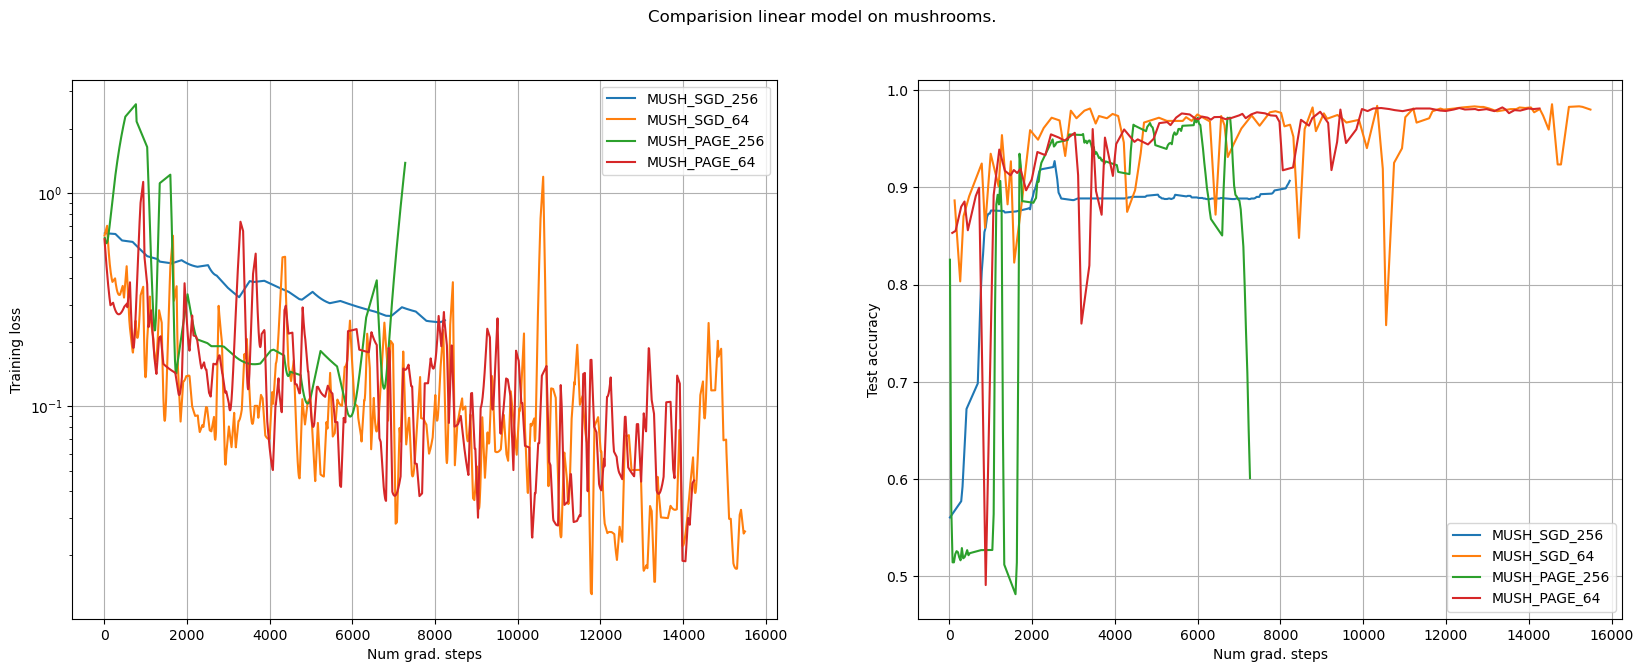

In [99]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(1, 2, figsize=(20, 7))

template = "mush"

page_lr = (L * (1 + np.sqrt((1 - prob_t) / (prob_t * batch_size_)))) ** -1
sgd_lr = (L) ** -1

values = []
values += [(i, j) for i, j in logger.items() if template in i and 'sgd' in i and '256' in i and str(sgd_lr * 0.1) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'sgd' in i and '64' in i and str(sgd_lr) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'page' in i and '256' in i and str(page_lr) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'page' in i and '64' in i and str(page_lr) in i]


for value in values:
    train_loss = [i[0] for i in value[1][0]]
    grad_steps_train = [i[1] for i in value[1][0]]
    valid_loss = [i[0] for i in value[1][1]]
    grad_steps_valid = [i[1] for i in value[1][1]]
    
    label = value[0].split('_')
    label.pop(2)
    label = "_".join(label)
    ax[0].plot(grad_steps_train, train_loss, label=label.upper())
    ax[1].plot(grad_steps_valid, valid_loss, label=label.upper())
    
ax[0].set_xlabel('Num grad. steps')
ax[1].set_xlabel('Num grad. steps')
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Test accuracy')
ax[0].set_yscale('log')

fig.suptitle('Comparision linear model on mushrooms.')

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.show()

We can see that for linear model and small dataset: PAGE with theoretical LR converges at the same level and competes only in setup with larger batch size. By the way, the authors in article mentioned this effect.

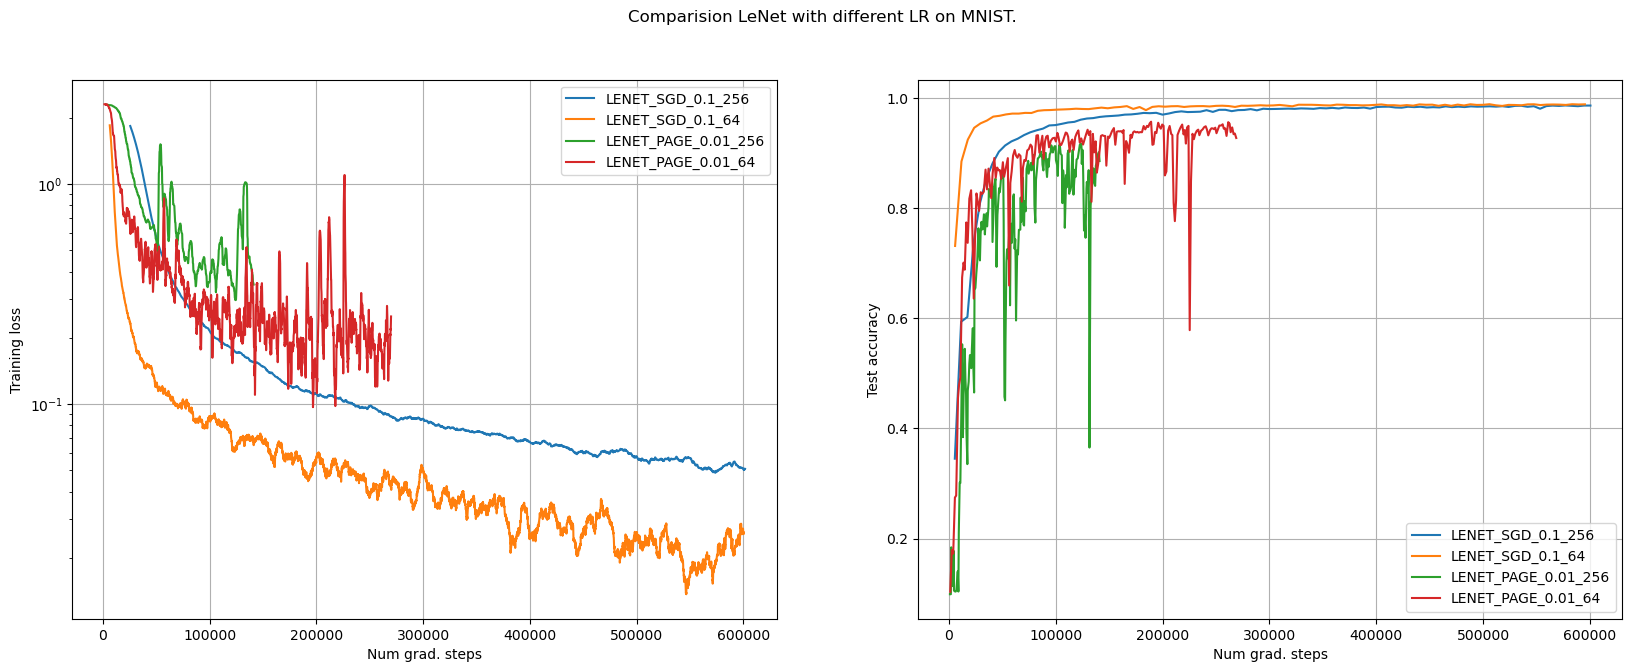

In [102]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(1, 2, figsize=(20, 7))

template = "lenet"


values = []
values += [(i, j) for i, j in logger.items() if template in i and 'sgd' in i and '256' in i and str(0.1) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'sgd' in i and '64' in i and str(0.1) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'page' in i and '256' in i and str(0.01) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'page' in i and '64' in i and str(0.01) in i]


for value in values:
    train_loss = [i[0] for i in value[1][0]]
    grad_steps_train = [i[1] for i in value[1][0]]
    valid_loss = [i[0] for i in value[1][1]]
    grad_steps_valid = [i[1] for i in value[1][1]]
    
    label = value[0]#.split('_')
    # label.pop(2)
    # label = "_".join(label)
    ax[0].plot(grad_steps_train, pd.Series(train_loss).rolling(100).mean(), label=label.upper())
    ax[1].plot(grad_steps_valid, valid_loss, label=label.upper())
    
ax[0].set_xlabel('Num grad. steps')
ax[1].set_xlabel('Num grad. steps')
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Test accuracy')
ax[0].set_yscale('log')

fig.suptitle('Comparision LeNet with different LR on MNIST.')

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.show()

Here can not see any superiority of PAGE. Though it work for the same number of steps it reached worse results.

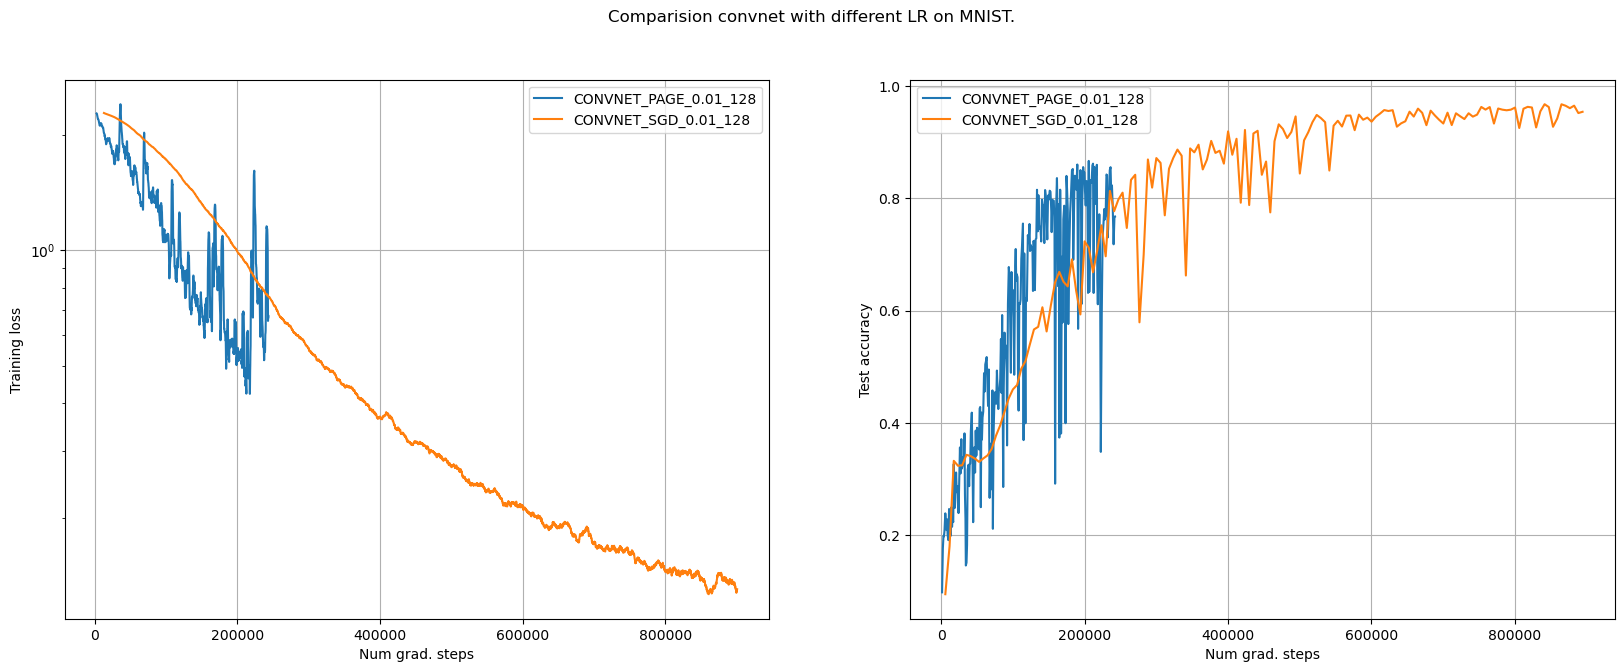

In [98]:
import matplotlib.pyplot as plt
import pandas as pd


fig, ax = plt.subplots(1, 2, figsize=(20, 7))

template = "convnet"


values = []
values += [(i, j) for i, j in logger.items() if template in i and 'page' in i and '128' in i and str(0.01) in i]
values += [(i, j) for i, j in logger.items() if template in i and 'sgd' in i and '128' in i and str(0.01) in i]



for value in values:
    train_loss = [i[0] for i in value[1][0]]
    grad_steps_train = [i[1] for i in value[1][0]]
    valid_loss = [i[0] for i in value[1][1]]
    grad_steps_valid = [i[1] for i in value[1][1]]
    
    label = value[0]#.split('_')
    # label.pop(2)
    # label = "_".join(label)
    ax[0].plot(grad_steps_train, pd.Series(train_loss).rolling(100).mean(), label=label.upper())
    ax[1].plot(grad_steps_valid, valid_loss, label=label.upper())
    
ax[0].set_xlabel('Num grad. steps')
ax[1].set_xlabel('Num grad. steps')
ax[0].set_ylabel('Training loss')
ax[1].set_ylabel('Test accuracy')
ax[0].set_yscale('log')

fig.suptitle('Comparision convnet with different LR on MNIST. ')

ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.show()

We also compared results on MNIST for small convolutional network. We can see that at the start of learning PAGE is leader. But in fact this both of methods do the same number of iterations. So in terms of time PAGE converge much slower and moreover it starts oscillate after large amount of steps.